In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install nltk
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
data=pd.read_csv("/content/drive/MyDrive/webscrape_MAMIA.csv")

In [77]:
def plot_most_frequent_words(dataframes, titles):
    
    # The count inidcates where in the subplot to go
    count = 0
    fig   = plt.figure(figsize   = (24,20),
                       facecolor = "white")
    
    # Enumerating allows for the list of titles to be referenced
    for d, dataframe in enumerate(dataframes):
        
        # Updating the location
        count += 1
        ax    = fig.add_subplot(2, 2, count)
        
        # Creating the graph
        sns.barplot(x       = 0,
                    y       = dataframe.index,
                    data    = dataframe,
                    palette = "deep")
        
        # Setting the graph parameters
        plt.title(f"Most Common Words From {titles[d]}", size = 20)
        plt.xlabel("Number Of Occurences", size = 18)
        plt.ylabel("Word", size = 18)
        plt.xticks(size = 16)
        plt.yticks(size = 17)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


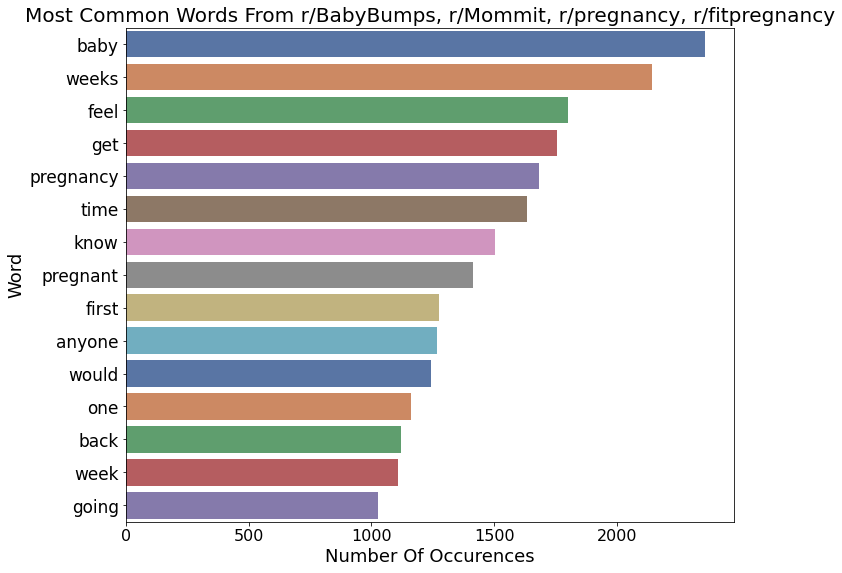

In [78]:
# Instantiating the count vectorizer

vectorizer = CountVectorizer()

# Masking the vectorizer with English stop words
nltk.download('stopwords')

new_stopwords = ["like", "just", "im", "dont",
                 "ive", "really", "want","also"]

stopwords= stopwords.words('english')
stopwords.extend(new_stopwords)
cvec_data= CountVectorizer(stop_words = stopwords)
vec= cvec_data.fit_transform(data["text"])

vec= pd.DataFrame(vec.toarray(),columns = cvec_data.get_feature_names())
vec=vec.sum()
vec_top= pd.DataFrame(vec.sort_values(ascending = False).head(15))

# Plotting the most common words
plot_most_frequent_words(dataframes=[vec_top],titles=['r/BabyBumps, r/Mommit, r/pregnancy, r/fitpregnancy'])

In [82]:
print(cvec_data.get_feature_names())


['aa', 'aaaaaaaaaahhhhhhhhh', 'aaaaand', 'aaaand', 'aampe', 'aampm', 'aaptiv', 'aashna', 'aat', 'ab', 'aback', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abate', 'abbas', 'abc', 'abcmouse', 'abd', 'abdefense', 'abdomen', 'abdomenpelvic', 'abdominal', 'abdominals', 'abide', 'abilities', 'ability', 'abilityduring', 'abit', 'abiut', 'able', 'abmats', 'abnormal', 'abnormalities', 'abnormality', 'abnormally', 'abort', 'abortion', 'abortions', 'aboutand', 'aboutany', 'aboutedited', 'abouti', 'aboutmerging', 'abouton', 'aboutspinach', 'abovealso', 'abrasions', 'abroad', 'abruption', 'abruptions', 'abruptly', 'abs', 'absence', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbs', 'absribs', 'abstain', 'abstained', 'abstract', 'absurd', 'absurdities', 'abt', 'abundance', 'abuse', 'abused', 'abusive', 'abysmally', 'ac', 'academic', 'academy', 'accelerations', 'accent', 'accept', 'acceptable', 'accepted', 'accepting', 'accepts', 'accesible', 'access', 'accessible', 'accessing', 'a